In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq
import sympy
import random
from importlib import reload
import Utils_cirq
reload(Utils_cirq)
from Utils_cirq import *
from cirq.contrib.svg import SVGCircuit
import scipy

In [2]:
agents = 3
p = 1

In [3]:
coalition_values = get_coalition(agents)
coalition_values

{'1': 30, '2': 40, '3': 25, '1,2': 70, '1,3': 60, '2,3': 65, '1,2,3': 90}

In [4]:
Q = get_Q(coalition_values, qubo_penalty = -500)

## Building the quantum circuit to solve the QUBO-Problem

In order to later plug in parameter values into the variational quantum circuit,
we need a dictionary to store the values for each parameter.

Following the naming convention from the paper we have β in the mixer layer and γ in the cost layer.

In cirq parameters are realized via the sympy.Symbol function

In [5]:
beta = [sympy.Symbol("β_"+str(i)) for i in range(p)]
gamma = [sympy.Symbol("γ_"+str(i)) for i in range(p)]
print(f"The beta and gamma variables: {beta} and {gamma}")

The beta and gamma variables: [β_0] and [γ_0]


After random initialization a parameter dictionary looks like this:

In [6]:
param_dict = {}
for i in range(p):
    param_dict[gamma[i]] = random.uniform(-2,2)
    param_dict[beta[i]] = random.uniform(-2,2)
param_dict

{γ_0: 1.7333898553285567, β_0: -1.4750094125962585}

### Initializing the circuit
Apply a hadamard gate on every qubit. The number of qubits is given by the size of the QUBO matrix

In [7]:
problem_size = len(Q)
qaoa, qubits = cirq_init(problem_size)

Note: the function also returns the qubits that are used in the circuit in order to address them later indiviually

#### Adding cost and mixer layer alternately p times


In [8]:
for i in range(p):
    qaoa = cost_layer(qaoa, qubits, gamma[i], Q)
    qaoa = mixer_layer(qaoa, qubits, beta[i])

Now the parameterized circuit looks like this:

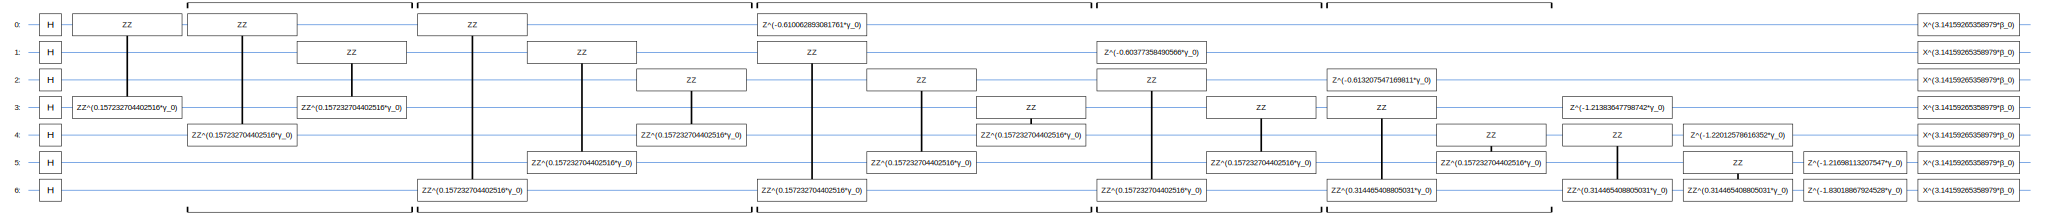

In [9]:
SVGCircuit(qaoa)

#### Training the circuit

To minimize the loss function  $L(\gamma,\beta) = \langle\gamma,\beta |H_c| \gamma,\beta\rangle$ for the training proccess , we construct $H_c$

https://link.springer.com/book/10.1007/978-1-4842-6522-2 Quantum Machine Learning with Python

https://youtu.be/YpLzSQPrgSc?t=836 Qiskit Global Summer School

$H_c = \sum_{i,j=1} ^{n}\frac{1}{4}Q_{i,j}Z_i Z_j-\sum_{i=1}^{n}c_iZ_i$
with $c_i = \sum_{j=1}^{n}Q_{i,j}$, the sum of the entries from the i-th row



In [10]:
H_c = m_op(Q)

Alternatively the function m_z(dim) creates a generic measurement operator for dim number of qubits

### Optimizing the parameters 

A simple SGD method is used to find the minimum for $L(\gamma,\beta)$, it tries to escape a local minimum by taking a random step.

Other methods like a sampling distribution based loss and QUBO cost on generic measurement were also tried, but did not prove to be time effective

Start at: {γ_0: 1.7333898553285567, β_0: -1.4750094125962585}
Epoch 1, Energy: -0.13495993754666435
Epoch 51, Energy: -0.23340642959243574
Epoch 101, Energy: -0.31593887112491914
Epoch 151, Energy: -0.38298124555899316
Epoch 201, Energy: -0.4017673482158405
Epoch 251, Energy: -0.4017673482158405
Epoch 301, Energy: -3.019318340582995
Epoch 351, Energy: -3.804993712419956
Epoch 401, Energy: -3.847149716932337
Epoch 451, Energy: -3.847149716932337
Epoch 501, Energy: -3.847149716932337
Epoch 551, Energy: -3.8486718827771504


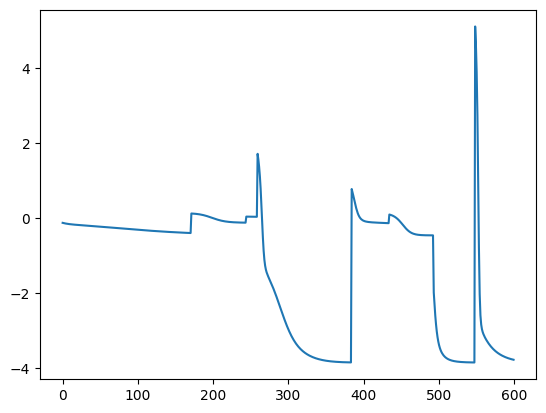

{γ_0: 0.3019134611506764, β_0: 1.129005640173842} -3.8486718827771504


In [11]:
print(f"Start at: {param_dict}")
# use prt = True so enable printouts and display the graph loss function value by epoch 
opt_params, opt_energy = exp_optim(param_dict.copy(), qaoa, lr=1, epochs=600, M=H_c, prt=True)
print(opt_params, opt_energy)

To obtain a solution a measurments are performed. For that we need to add a measurement layer to the QAOA circuit

In [12]:
measure_qaoa = qaoa.copy()
measure_qaoa.append(cirq.measure(qubits, key = 'result'))

We can now perform measurements to see what results are most probable

cirq.ParamResolver({sympy.Symbol('γ_0'): 0.3019134611506764, sympy.Symbol('β_0'): 1.129005640173842})


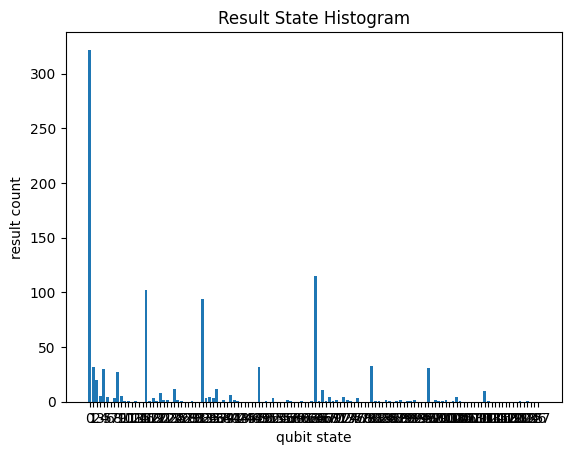

[(0, 322), (64, 115), (16, 102), (32, 94), (80, 33), (48, 32), (1, 32), (96, 31), (4, 30), (8, 27)]


In [13]:
simulator = cirq.Simulator()
num_reps = 1000
params = cirq.ParamResolver(opt_params)
print(params)
measure_result = simulator.run(measure_qaoa, param_resolver=params, repetitions = num_reps)

cirq.plot_state_histogram(measure_result, plt.subplot())
plt.show()
counts = measure_result.histogram(key='result')
solution = counts.most_common(10)
print(solution)
moco_prob = counts.most_common(1)[0][1]/num_reps


The results need to be decoded to be interpretable

In [14]:
sol, num, prob = find_sol(counts, coalition_values)
print(f"Best coalition: {sol}\nProbabilty: {prob}")
most_common = solution[0][0]
moco = decode(to_bin_array(most_common, agents), coalition_values)
print(f"Most frequent measurment:{moco}\nProbabilty: {moco_prob}")

Best coalition: [{'2'}, {'3', '1'}]
Probabilty: 0.012
Most frequent measurment:[]
Probabilty: 0.322


### Visualize the parameter space using a grid search for p=1 (two parameters)

With gamma_max and beta_max we can define the +/- range of the grid search

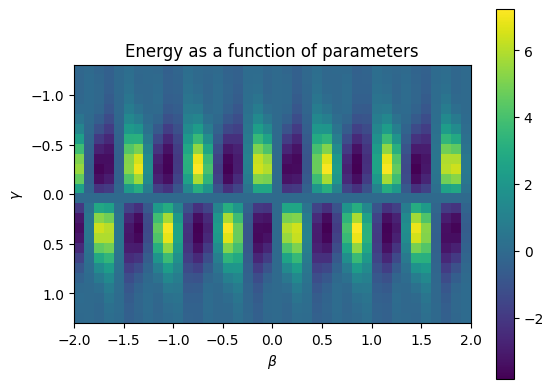

Numerically found parameters: Gamma = -0.3019134611506764, Beta = -0.5
Energy = -3.8416160181132746


In [15]:
if p ==1:
    gamma_max = abs(opt_params[gamma[0]])+1
    beta_max = 2 # ranges of the parameter
    res = 10 # granularity of the image
    
    
    g_size = int(gamma_max * res)
    b_size = int(beta_max * res)
    energies = np.zeros((2 * g_size, 2 * b_size))
    for g in range(-g_size, g_size):
        for b in range(-b_size, b_size):
            vec = state_vector_params(g/g_size*gamma_max, b/b_size*beta_max, qaoa)
            energies[g+g_size, b+b_size] = vec @ H_c @ vec

    """Plot the energy as a function of the parameters 𝛄 and β found in the grid search."""
    plt.ylabel(r"$\gamma$")
    plt.xlabel(r"$\beta$")
    plt.title("Energy as a function of parameters")
    plt.imshow(energies, extent=(-beta_max, beta_max, gamma_max, -gamma_max))
    plt.colorbar()
    plt.show()
    
    ind = np.unravel_index(np.argmin(energies, axis=None), energies.shape)
    ind_gam, ind_bet = ind
    eng = energies[ind]
    opt_gam = -gamma_max + ind_gam / res
    opt_bet = -beta_max + ind_bet / res
    print(f"Numerically found parameters: Gamma = {opt_gam}, Beta = {opt_bet}\nEnergy = {eng}")

In [16]:
if p == 1:
    ga = opt_gam
    be = opt_bet
    vec = state_vector_params(ga, be, qaoa)
    im_en = vec @ H_c @ vec
    ga = opt_params[gamma[0]]
    be = opt_params[beta[0]]
    vec = state_vector_params(ga, be, qaoa)
    op_en = vec @ H_c @ vec

    print(f"Grid energy: {im_en}, Optimizer energy:{op_en}")
    print(f"Energy lower than optimizer: {im_en <= op_en}")

Grid energy: -3.8421665142223764, Optimizer energy:-3.8486718827771504
Energy lower than optimizer: False


Measurment results for parameters found by grid search

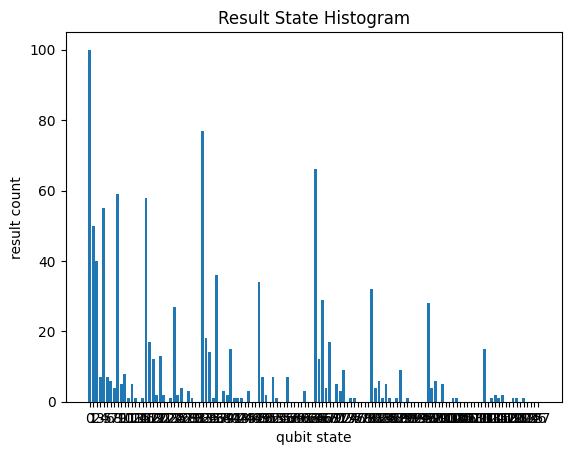

[(0, 100), (32, 77), (64, 66), (8, 59), (16, 58), (4, 55), (1, 50), (2, 40), (36, 36), (48, 34)]


In [17]:
if p == 1:    
    plot_dict = {}
    for i in range(p):
        plot_dict[gamma[i]] = opt_gam  
        plot_dict[beta[i]] = 2
        plot_params = cirq.ParamResolver(plot_dict)
    plot_result = simulator.run(measure_qaoa, param_resolver=plot_params, repetitions = num_reps)

    cirq.plot_state_histogram(plot_result, plt.subplot())
    plt.show()
    counts = plot_result.histogram(key='result')
    solution = counts.most_common(10)
    print(solution)
    moco_prob = counts.most_common(1)[0][1]/num_reps

In [18]:
if p == 1:
    sol, num, prob = find_sol(counts, coalition_values)
    print(f"Best coalition: {sol}\nProbabilty: {prob}")
    most_common = solution[0][0]
    moco = decode(to_bin_array(most_common, agents), coalition_values)
    print(f"Most frequent measurment:{moco}\nProbabilty: {moco_prob}")

Best coalition: [{'2'}, {'3', '1'}]
Probabilty: 0.036
Most frequent measurment:[]
Probabilty: 0.1


### Using cobyla

Experimenting with cobyla didn't always lead to a lower energy when the starting point is too far from the optimal solution. Changes in rhobeg can help here

In [19]:
def get_energy(para_array):
    vec = state_vector_params(para_array[0], para_array[1], qaoa)
    return vec @ H_c @ vec

def constr1(x):
    "beta should be greater than -2"
    return x[1] + 2
def constr2(x):
    "beta should be smaller than 2"
    return -x[1] + 2

if p == 1:

    init = [random.uniform(-4,4), random.uniform(-1,1)]

    cob_array = scipy.optimize.fmin_cobyla(get_energy, init, [constr1, constr2], rhobeg=2.0, rhoend=0.0001, maxfun=1000, catol=0.0002)
    print(f"Cobyla gamma: {cob_array[0]}, beta: {cob_array[1]}")
    cob_en = get_energy(cob_array)
    print(f"Cobyla energy: {cob_en}\n")
    print(f"Energy lower than optimizer? {op_en >= cob_en}")

Cobyla gamma: 1.1004906059494364, beta: 1.9921304220727107
Cobyla energy: -0.19211705553149716

Energy lower than optimizer? False


Measurment results for parameters found by cobyla

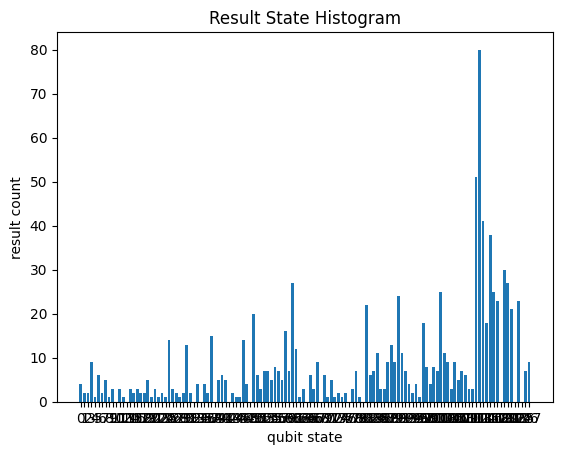

[(113, 80), (112, 51), (114, 41), (116, 38), (120, 30), (121, 27), (60, 27), (102, 25), (117, 25), (90, 24)]


In [20]:
if p == 1:
    cob_dict = {}
    for i in range(p):
        cob_dict[gamma[i]] = cob_array[0]  
        cob_dict[beta[i]] = cob_array[1]
        cob_params = cirq.ParamResolver(cob_dict)
    cob_result = simulator.run(measure_qaoa, param_resolver=cob_params, repetitions = num_reps)

    cirq.plot_state_histogram(cob_result, plt.subplot())
    plt.show()
    counts = cob_result.histogram(key='result')
    solution = counts.most_common(10)
    print(solution)
    moco_prob = counts.most_common(1)[0][1]/num_reps

In [21]:
if p == 1:   
    sol, num, prob = find_sol(counts, coalition_values)
    print(f"Best coalition: {sol}\nProbabilty: {prob}")
    most_common = solution[0][0]
    moco = decode(to_bin_array(most_common, agents), coalition_values)
    print(f"Most frequent measurment:{moco}\nProbabilty: {moco_prob}")

Best coalition: [{'2'}, {'3', '1'}]
Probabilty: 0.002
Most frequent measurment:[{'1'}, {'2'}, {'3'}, {'3', '2', '1'}]
Probabilty: 0.08


### Conclusion

Both methods lack completeness in terms of finding the lowest energy level.
For up to 3 agents they show soundness, but not in terms of finding the correct solution with the highest probability. The reason could be that H_c, though with the best of conscience and knowledge implemented, is not correct.<br>
When using 4 agents the construction of $H_c$ takes unreasonably long. Therefore a the methods for sampling distribution approaches were devoloped to circumvent this but for the cost of much more training time and also without completness garantee.